# ECE113 Lab2 - Time Frequency
<br>
<small>Spectrogram part was originally designed by John Pauly,  modified and extended to include SDR and FM processing by Michael Lustig, Translated to python by Frank Ong and Michael Lustig. Updated for UCLA ECE113, Spring 2021</small>

In this lab, we will look at the processing and spectrum of time-varying signals. In the first part of the lab we will look at the Short-Time Fourier Transform and spectrograms. We will use this to analyze audio signals and broadcast FM.

In [1]:
!conda install -c conda-forge python-sounddevice

Solving environment: ...working... done

# All requested packages already installed.



If you have problems importing sounddevice, please shut down jupyter notebook, open anaconda prompt, run 'conda install -c conda-forge python-sounddevice', open jupyter notebook and try to import it one more time

In [2]:
# Import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
import scipy.io.wavfile as wavfile
import scipy.signal as signal
from matplotlib.pyplot import *
import sounddevice as sd

## Part I: Spectrograms
In class we used the DFT to estimate the frequency of a segment of a signal. When we do this, we are implicitly assuming that the frequency is constant over that interval.  This is a reasonable assumption for some signals, especially for a very short time windows. 
 
There are many times when we'd like analyze signals whose frequency is changing over time.  In fact, most signals aren't interesting unless they do change! There are many examples, including speech, music, and the sounds that surround you in daily life.  In this lab we will learn how to process these signals to determine how their spectrum changes with time.

The basic problem is that we have long segment of a signal $x[n]$, where $n=0, ... ,N-1$.  We want to know what its frequency is as a function of time.  There are two basic approaches.  One is to pass the signal through a bank of bandpass filters, and plot the outputs of the filters as a function of time.  

The second approach is based on the short-time Fourier transform (STFT) and is to break the signal up into short segments, and compute the spectrum of each of these separately.  This is the approach we will use in this lab.

To obtain these, possibly overlaping, segments, the signal is multiplied by a sliding window. One key design parameter here is the window length which determines both time and frequency resolutions of STFT. The wider the window is, the higher frequency resolution we will have (think about the sharper/narrower sinc in the frequency domain) but our time resolution will be lower. In contrast, the narrower the window is, there will be less variation in the time-domain characteristics of the signal within the widnow duration. In other words, with narrower window, we will have better time resolution but our frequency resolution would get worse. This is why, with STFT, we cannot improve both time and frequency resolution simultaneously! This is sometimes known as the uncertainly principle with the Fourier analysis.  

A sample signal is shown in Figure 1. Obviously you can tell that the amplitude is changing as a function of time. When you examine the signal closely, you can also tell that the frequency is changing.
Since the frequency is changing, we want to break the signal into segments over which the frequency is relatively constant.  Then we will analyze each segment using the DFT.  The result of analyzing the first 256 samples, and another block of 256 samples that is 1024 samples later is shown in Figure 2.  As is the convention with the DFT, zero frequency is the first sample, and the Nyquist rate corresponds to the middle sample. The sampling rate in this example was 8192Hz, so the maximum frequency is 4096Hz. Note that the frequency has dropped about 300 Hz between the first and second block.

<center><img src="sampsig.png" alt="sampsig" style="width: 600px;"/></center>
<center>Figure 1: A segment of a sampled bird song.</center>

For a long signal, there would be a tremendous number of plots that would have to be examined, and this doesn't convey the information very effectively.  Instead, the most common presentation is to display the information in an image format, with frequency on the vertical axis, time on the horizontal axis, and the value of a particular pixel being the magnitude of the spectra at that time and frequency. Remember that STFT is essentially a function of two variables: time and frequency. So spectrograms are typically shown as heatmap diagrams where the color at each point on the time-frequency grid would show the STFT magnitude at that point. 

For the first 4 tasks, we are assuming that the signal is real and the magnitude of the spectrum is symmetric about the origin.  We therefore need only display the positive frequencies.  Later, in task 5 where we acquire data using the SDR the signal is going to be complex and we will need to display both positive and negative frequencies. This presentation is known as a spectrogram.

<center><img src="two_segmentsc.png" alt="two_segmentsc" style="width: 600px;"/></center>
<center>Figure 2: The spectra from two 256 sample blocks of the signal from Fig. 1</center>

An example of this type of plot for the signal that Fig. 1 was taken from is shown in Fig. 3:
<center><img src="bird_spectroc.png" alt="bird_spectroc" style="width: 600px;"/></center>
<center>Figure 3: A segment of a sampled bird song.</center>

A function that takes a two-dimensional array y and makes an image of the log-magnitude is given below:

In [3]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spectrum in db

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
 
    fig=figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig
    

The only parameter of note is dbf which determines the dynamic range in dB that will be presented. The default is 60 dB, or a factor of 1000. This allows you to see small spectral components without seeing all of the background noise, and is reasonably suitable for our purposes here. For other applications with higher or lower noise levels, you may want to change this. For example in Task 5, the signal to noise ratio coming out of the SDR will require adjusting the dynamic range (somewhere between 20-40 was appropriate for my reception)

Several different sound files are available on the class web site to for you to work with.  These are

- `s1` A bird call.

- `s2` A creaking door.

- `s3` An orca whale call.

- `s4` A sound effect.

- `s5` 24Week Fetal Doppler Ultrasound 



Read each .wav file with the function `(fs, data) = wavfile.read( filename )` and play them with the following commands:
    
```
sd.play(data, fs,Blocking=True)
```


**Task:** Play all the wav files:
```
s1.wav - Bird chirping
s2.wav - Door closing
s3.wav - Orca Whale
s4.wav - Instrument
s5.wav - Doppler ultrasound of a baby heart
```
Try to visualize what you would expect the spectrum to look like as a function of time.  In each case, the sampling rate is 44100 Hz.

In [4]:
## Play sounds
fname = "s1.wav"
# get sound file
(fs, data) = wavfile.read(fname)

sd.play(data,fs,blocking=True)

In [5]:
(fs2, data2) = wavfile.read("s2.wav")
sd.play(data2,fs2,blocking=True)

In [6]:
(fs3, data3) = wavfile.read("s3.wav")
sd.play(data3,fs3,blocking=True)

In [7]:
(fs4, data4) = wavfile.read("s4.wav")
sd.play(data4,fs4,blocking=True)

In [8]:
(fs5, data5) = wavfile.read("s5.wav")
sd.play(data5,fs5,blocking=True)

Try to visualize in your head, what you would expect the spectrum to look like as a function of time.  In each case, the sampling rate is 44100 Hz.


### Task 1: Computing a simple spectrogram

<center><img src="rect_win.png" alt="rect_win" style="width: 400px;"/></center>
<center>Figure 4: Extracting a segment of a long signal with a rectangular window</center>

For our first attempt at making a spectrogram, we will simply take the original signal of length N, and split it into blocks of length M. We then compute the DFT of each block. This corresponds to using a rectangular window to extract each block from the signal, as is illustrated in Fig. 4.

Write a python function that computes the spectrogram for a signal. If the original signal is a vector `x`, It should

  * Break the signal up into `m`-sample blocks, stored in the columns of a 2D matrix `xm`. This may require padding the signal with zeros, so that the length is a multiple of the block size.

  * Apply the fft to the matrix using `xmf = fft(xm,len(xm),axis=0)`. This operation applies FFT along each column of the matrix. It does not do a 2D FFT.

  * Compute ranges for time `t_range` and frequency `freq_range`

  * Call `sg_plot(t_range,f_range,xmf[0:m//2,:])`, where we are only plotting the positive frequencies. Your routine should be invoked with

        myspectrogram(x,m,fs)
    
  where `x` is the signal, `m` is the block size and `fs` is the sampling rate in Hz.
  

One trick that can help you here is the reshape command. To create the `xm` matrix, first zero pad `x` to be a multiple of `m` in length:
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m  # // enforces integer division
    xp = append(x,zeros(-lx+nt*m))
    
Use reshape to make it an m by nt  matrix in column major fashion. The order 'F' means a Fortran order, which is column first as opposed to the 'C' order, which is C language order and is row first.  Matlab uses a default of column order, whereas numpy uses a default of row order:
    
    xm = reshape( xp, (m,nt), order='F')

Each column of `xm` is one block of `x`.

To compute the time and frequency range, recall that the DFT frequencies go from `0` to the sampling frequency `fs` Hz in steps of `fs/m` Hz. We are only going to plot the positive frequencies, so 

        f_range = [0.0, fs / 2.0]
    
The time of a particular block is the period of one sample, `1/fs` seconds, multiplied by the number of samples in the block. If there are nt blocks, the time range is

        t_range = [0.0, lx / fs]
    
Try your spectrogram routine with the bird call sound file, `s1`, with a block size of `256` samples. Note, that the sampling rate of the data is `44100` Hz (Compact Disc rate). The spectrogram should look vaguely reminiscent of Fig. 3. However, there is noticeable streaking in the spectral dimension. Include a copy of this spectrogram in your notebook.

#### Solution for Task 1: 

In [5]:
def myspectrogram(x,m,fs, dbf=60):
    # function myspectrogram(x,m,fs)
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    # Inputs: 
    #         x - data
    #         m - window size
    #         fs - sampling rate
    
    # Your code here
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m  # // enforces integer division
    xp = append(x,zeros(-lx+nt*m))
    xm = reshape( xp, (m,nt), order='F')
    
    # Task 1: Rectangular windowing
    
    # take fft
    xmf = fft(xm,len(xm),axis=0)
    # compute time and frequency ranges
    f_range = [0.0, fs / 2.0]
    t_range = [0.0, lx / fs]
    
    fig = sg_plot(t_range,f_range,xmf[0:m//2,:])
    
    return fig


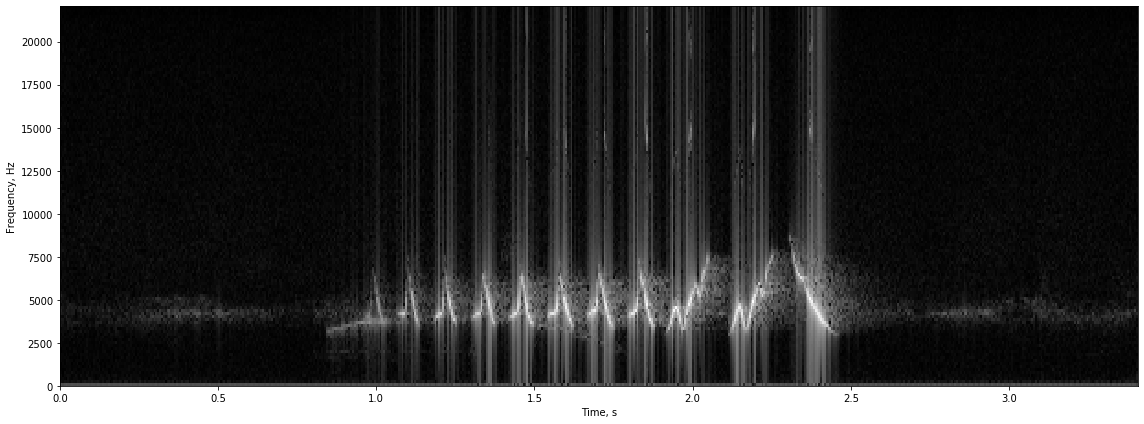

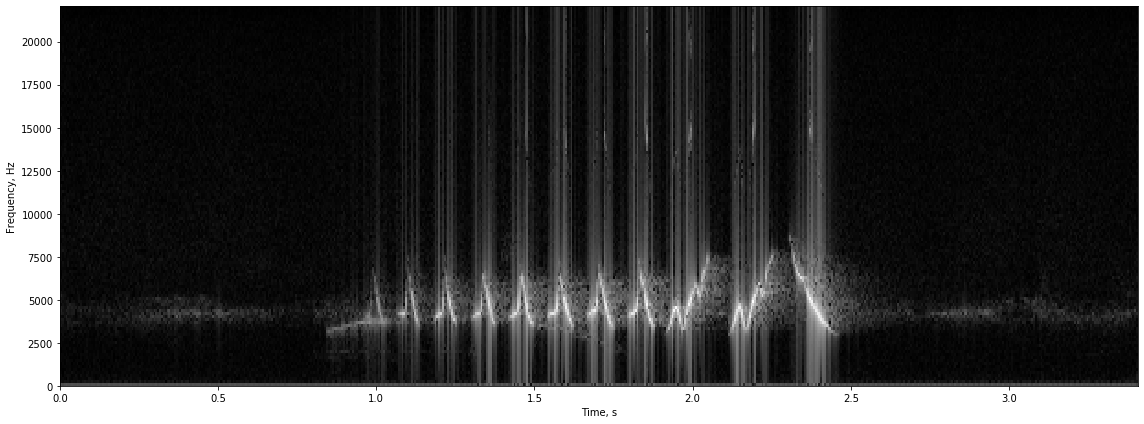

In [6]:
# Plot
# block size of 256
myspectrogram(data,256,fs)

### Task 2: A better spectrogram.

Similarly to the general windowing problem in DFT, the problem with the spectrogram from task 1 is that we have used a rectangular window to cut out blocks of the signal. In the spectral domain this corresponds to convolving a periodic sinc with the spectra. The sinc sidelobes are high, and fall off slowly. We need to do something a little more gentle with the data.

To improve our spectrogram, we will extract each block of data with a Hann window. We can do this by multiplying our `xm` matrix with a matrix that has a Hann window along its columns,

    xmw = xm * outer(hanning(m), ones(nt) );

The `outer(hanning(m), ones(nt) )` term is a matrix that has the same Hann window in each of the nt columns. 

Another more pythonic way is to use broadcasting:

     xmw = xm * hanning(m)[:,None]

Incorporate this into your a new  `myspectrogram_hann(x,m,fs)` function. 

Try your function on the bird song again. This time the spectrogram should look very similar to the Fig. 3. The location and size of the windows is shown in Fig. 5. Note that parts of the signal are effectively not used, at the ends of each window. This can result in discontinuities in the temporal direction of the spectrogram.



<center><img src="hann_win.png" alt="hann_win" style="width: 400px;"/></center>
<center>Figure 5: Extracting segments of a long signal with a Hann window</center>

#### Solution for Task 2:

In [7]:
def myspectrogram_hann(x,m,fs):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a Hanning window
    
    # Inputs: 
    #         x - data
    #         m - window size
    #         fs - sampling rate
    
    # Your code here
    
    # Task 2: Hanning windowing
    lx = len(x);
    nt = (lx + m - 1) // m  # // enforces integer division
    xp = append(x,zeros(-lx+nt*m))
    xm = reshape( xp, (m,nt), order='F')
    
    # get hanning window
    xmw = xm * outer(hanning(m), ones(nt) );
    
    # take fft
    xmf = fft(xmw,len(xm),axis=0)
    # compute time and frequency ranges
    f_range = [0.0, fs / 2.0]
    t_range = [0.0, lx / fs]
    
    fig = sg_plot(t_range,f_range,xmf[0:m//2,:])
    
    return fig



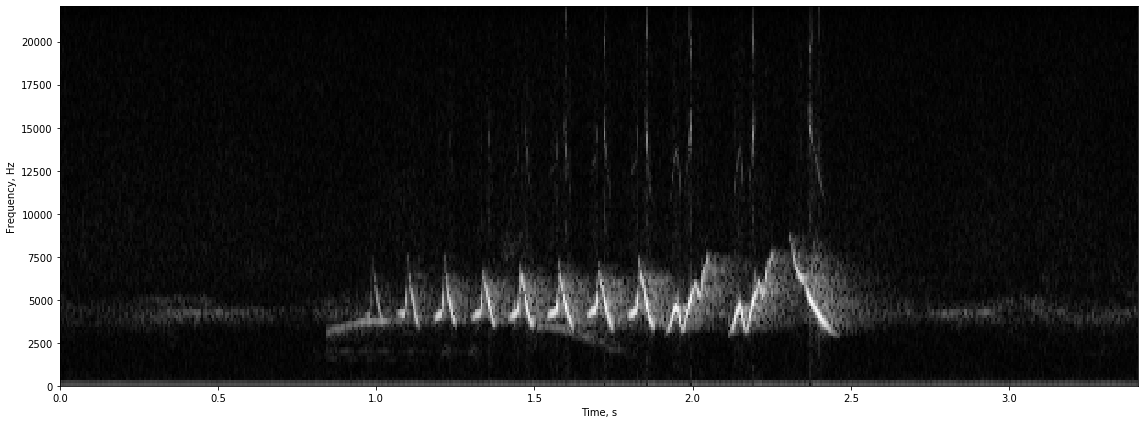

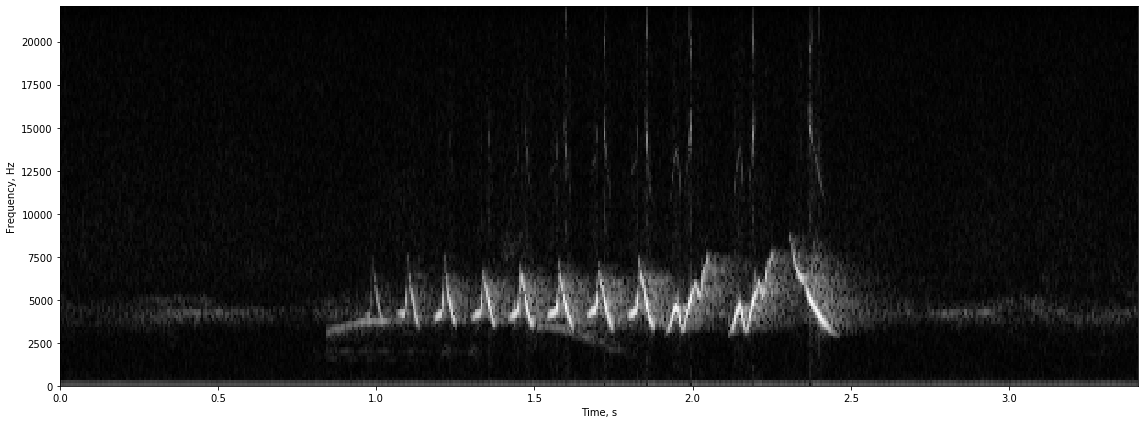

In [8]:
# Plot
myspectrogram_hann(data,256,fs)

### Task 3: An even better spectrogram!

As a final enhancement, we will overlap the Hann windows, as shown in Fig. 6. Each block of the signal, and column of the `xm` matrix overlaps the adjacent blocks by 50%.  There are a number of ways to do this in python.    One is to replicate each half block in `xp` before the reshape.  Another direct approach would be to program it in a `for` loop.  Note that you also have to modify the time vector, since you have twice as many time samples. Incorporate this into a new  `myspectrogram_hann_ovlp(x,m,fs)` function. 

Try this on the bird song.  it should look much smoother than the previous case. 

<center><img src="ol_hann_win.png" alt="ol_hann_win" style="width: 400px;"/></center>
<center>Figure 6: Extracting segments of a long signal with a Hann window</center>

#### Solution for Task 3:

In [9]:
def myspectrogram_hann_ovlp(x,m,fs, dbf=60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    # Inputs: 
    #         x - data
    #         m - window size
    #         fs - sampling rate
    
    # Your code here
    
    # Task 3: Overlapped Hanning windowing
    lx = len(x);
    nt = (lx + m - 1) // m  # // enforces integer division
    xp = append(x,zeros(-lx+nt*m))
    
    # replicate each half block
    xm = xp.reshape((m//2,nt*2), order='F')
    xm = concatenate((xm,xm),axis=0)
    xm = xm.reshape((m*nt*2,1),order='F')
    #xm = reshape(xm, (m,nt*2), order='F')
    xm = xm[r_[m//2:len(xm),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    # get hanning window
    xmw = xm * outer(hanning(m), ones(nt*2) );
    
    # take fft
    xmf = fft(xmw,len(xm),axis=0)
    # compute time and frequency ranges
    f_range = [0.0, fs / 2.0]
    t_range = [0.0, lx / fs]
    
    fig = sg_plot(t_range,f_range,xmf[0:m//2,:])
    
    return fig


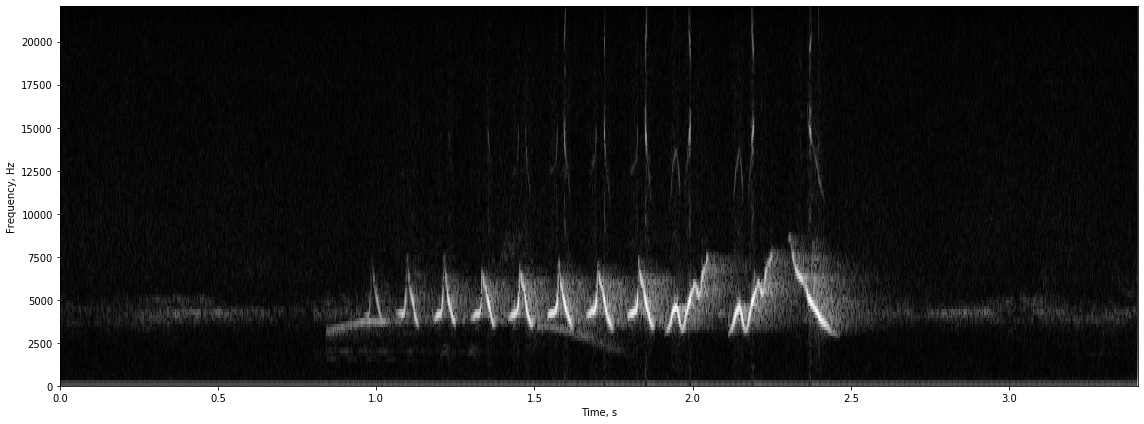

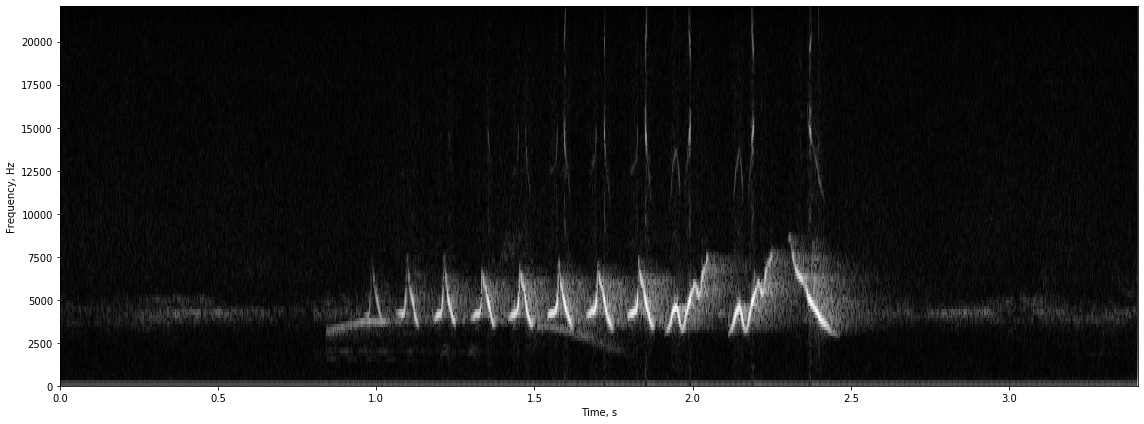

In [10]:
# Plot
myspectrogram_hann_ovlp(data,256,fs)

### Task 4: Time and frequency resolution.

So far we've just set the block size to 256 samples, which is about 5.8 ms of data.  The frequency resolution is then 44100/256 = 172.27 Hz.  Ideally we'd like to have both time and frequency resolution. However, as described earlier, one comes at the expense of the other.  For example if we wanted to improve our frequency resolution to 86.13 Hz, it would increase the time between samples to 11.6 ms.

The optimum tradeoff between the two factors depends on the nature of the spectrum you are analyzing.  A good example is the orca whale call, signal s3.  This has segments that are very rapidly changing, and segments where the changes are slow.  Try different block sizes, from 128, 256, 512, and 1024 samples.  Note how the frequency resolution improves, while the temporal resolution degrades.

#### Solution for Task 4:

In [13]:
# get sound file
fname = "s3.wav"
(fs, data) = wavfile.read(fname)

# Plot the spectrogram for each block size

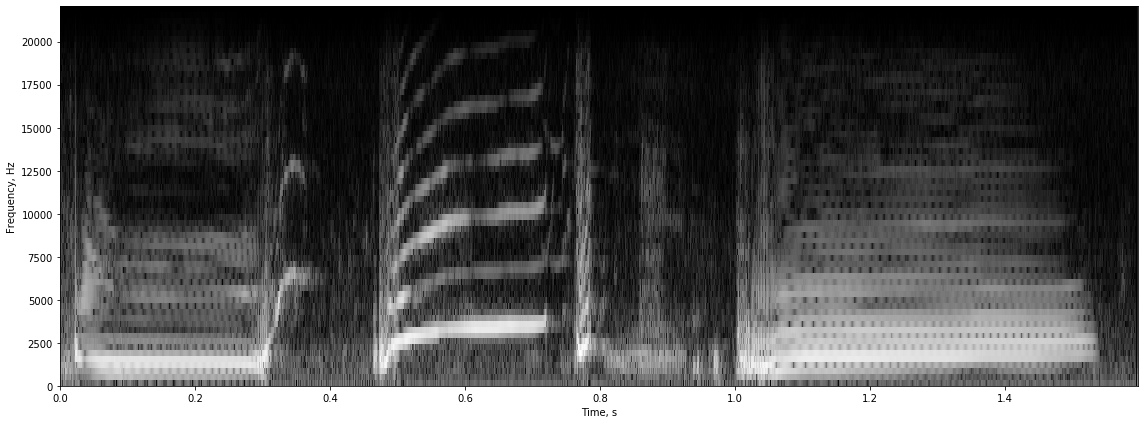

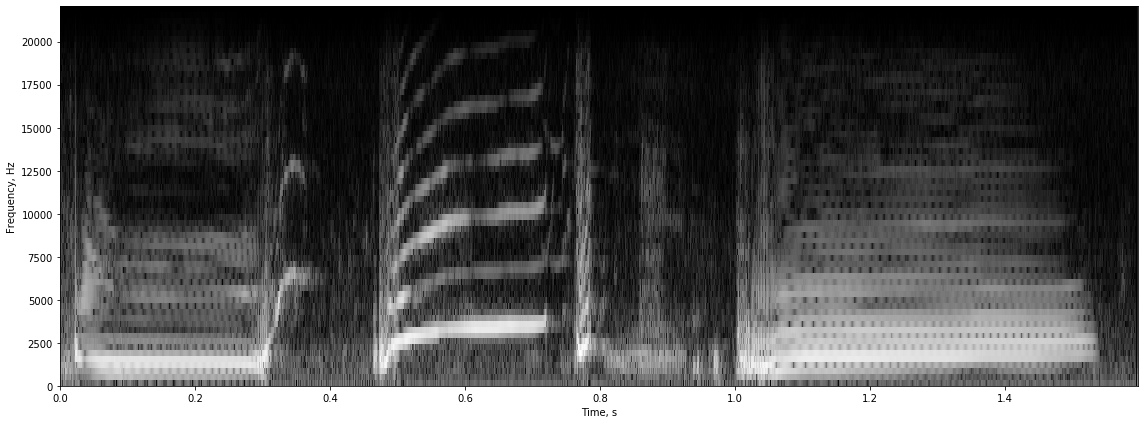

In [19]:
myspectrogram_hann_ovlp(data,128,fs)

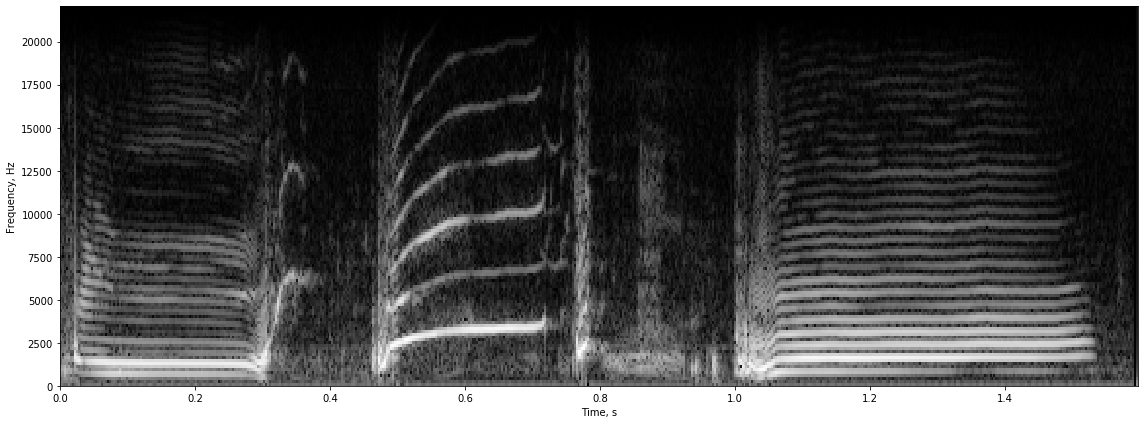

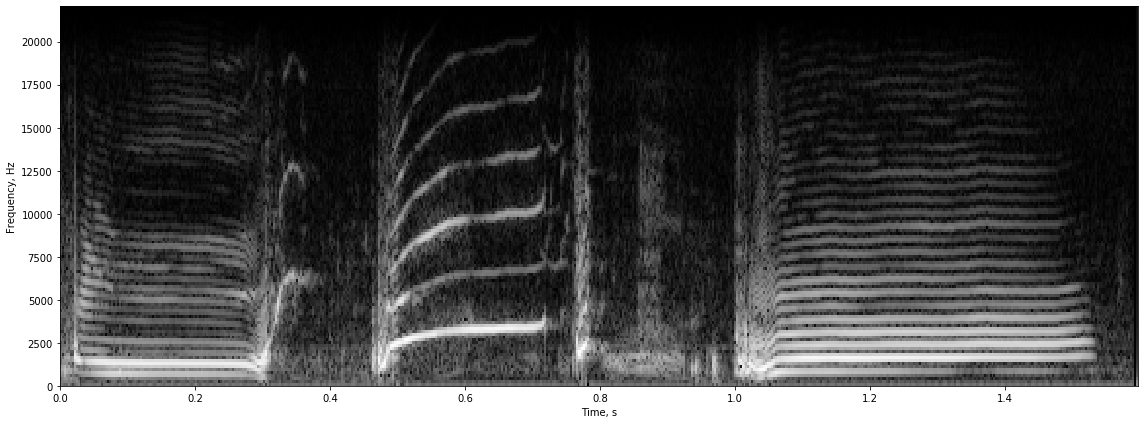

In [15]:
myspectrogram_hann_ovlp(data,256,fs)

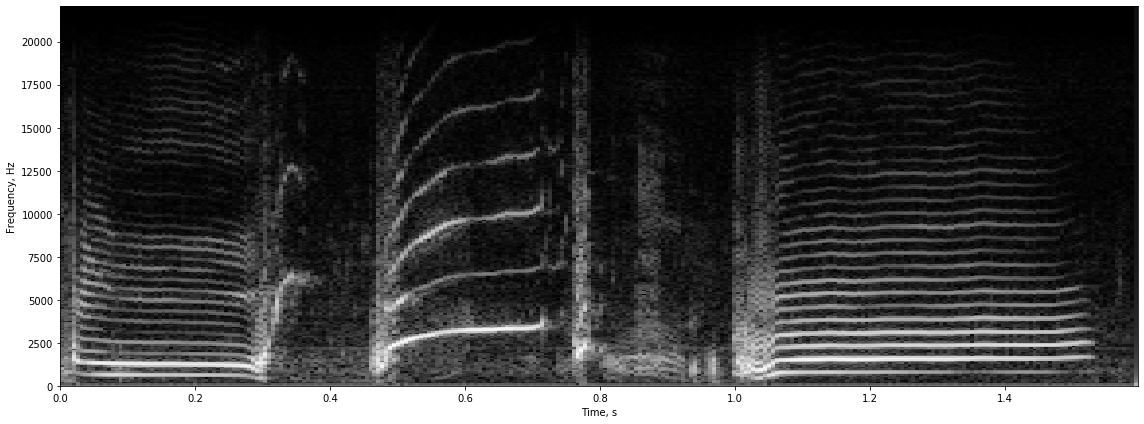

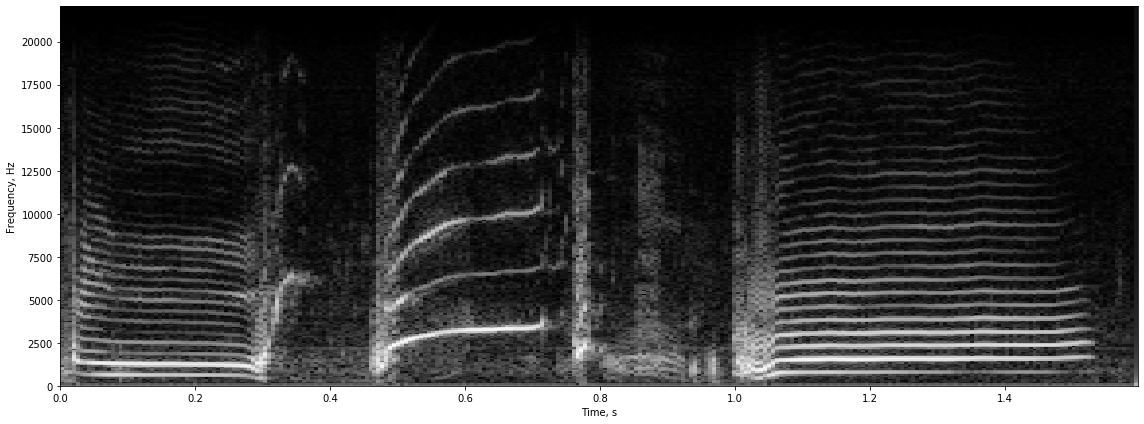

In [16]:
myspectrogram_hann_ovlp(data,512,fs)

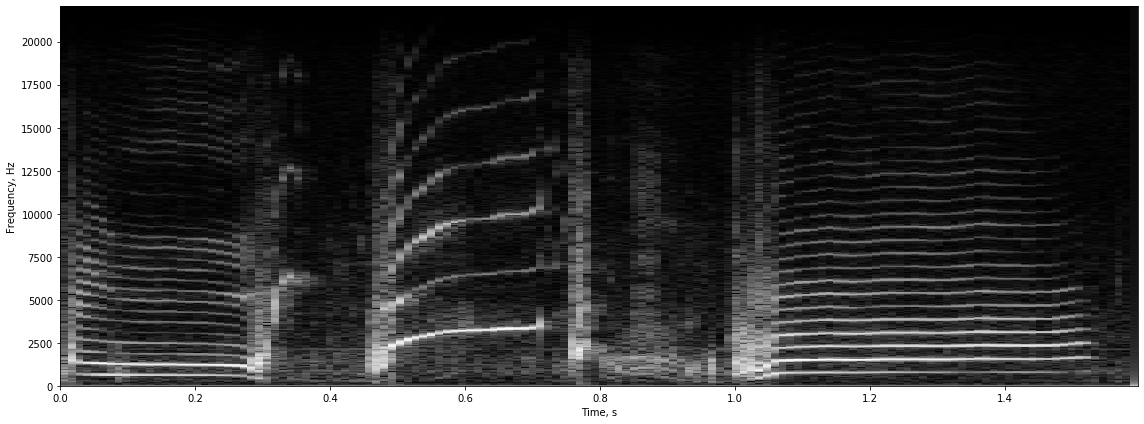

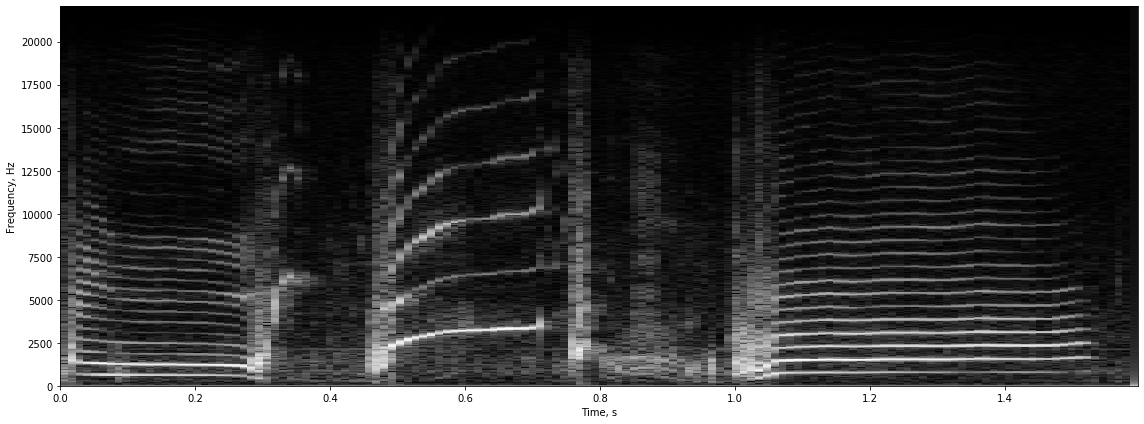

In [17]:
myspectrogram_hann_ovlp(data,1024,fs)

Increasing the block size improves the frequency resolution but degrades the temporal resolution.

# You are now ready to move on to Part II of the lab!